# Pleiades: preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Pleiades">
             Initial value problem: Pleiades</a></li>     
                          
<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations-(Second-Order-ODE)">
              Float64 Computations (Second Order ODE)</a></li>

<li><a href="#Float128-Computations-(General-ODE-Problem)">
              Float128 Computations (General ODE Problem)</a></li>

<li><a href="#Float128-Computations-(Second-Order-ODE)">
              Float128 Computations (Second Order ODE)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

- PLEI- a celestial mechanics problem: seven stars in the plane with coordinates $x_i,y_i$ and masses $m_i=i$ ($i=1,\dots,7$)  

\begin{align*}
&x_i^{''}=\sum_{j \ne i} m_j(x_j-x_i)/r_{ij} \\
&y_i^{''}=\sum_{j \ne i} m_j(y_j-y_i)/r_{ij} 
\end{align*}

where

\begin{align*}
r_{ij}=((x_i-x_j)^2+ (y_i-y_j)^2)^{3/2}, \quad i,j=1,\dots,7
\end{align*}

- The initial values are

\begin{align*}
& x_1(0)=3, \quad x_2(0)=3, \quad x_3(0)=-1, \quad x_4(0)=-3, \\
& x_5(0)=2, \quad x_6(0)=-2, \quad x_7(0)=2 \\
& y_1(0)=3, \quad y_2(0)=-3, \quad y_3(0)=2, \quad y_4(0)=0, \\
& y_5(0)=0, \quad y_6(0)=-4, \quad y_7(0)=4, \\
& x'_i(0)=y'_i(0)=0 \ \text{ for all } i \text{ with the exception of} \\
& x'_6(0)=1.75, \quad x'_7(0)=-1.5, \quad y'_4(0)=-1.25, \quad y'_5(0)=1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Solving Ordinary Differential Equations I (Nonstiff Problems), E.Hairer, S.P:Norsett, G.Wanner, (245 page), Springer

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using Plots
using Dates,LaTeXStrings
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Pleiades

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/Pleiades.jl")
include("../ODEProblems/InitialPleiades.jl")

t0=0.0
t1=3.0

u064 =InitialPleiades(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(f,u064,tspan64);

u0128=InitialPleiades(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(f,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

q064=copy(u064[1:14])
v064=copy(u064[15:28])
probdyn64 = DynamicalODEProblem(dotq,dotv,q064,v064,tspan64)
prob2nd64 = SecondOrderODEProblem(f2nd!,v064,q064,tspan64)


q0128=copy(u0128[1:14])
v0128=copy(u0128[15:28])
probdyn128 = DynamicalODEProblem(dotq,dotv,q0128,v0128,tspan128)
prob2nd128 = SecondOrderODEProblem(f2nd!,v0128,q0128,tspan128);

<a href="#top">Back to the top</a>

## Test solution

In [6]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/plei_test_sol.jld2" sol

@load "./Data/plei_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256 =InitialPleiades(BigFloat)
Gm256=BigFloat.([1,2,3,4,5,6,7])

E0=NbodyEnergy(u0256,Gm256)
(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0.-1))

(3.0f0, 5.9543627f-33)

<a href="#top">Back to the top</a>

## Float64 Computations (Second Order ODE)

## Vern9

In [7]:
sol9 =solve(probdyn64,Vern9(),abstol=1e-12,reltol=1e-12);
sol9.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  5538
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          321
Number of rejected steps:                          25

### DPRK12

In [8]:
sol8 =solve(prob2nd64,DPRKN12(),abstol=1e-12,reltol=1e-12);
sol8.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  3624
Number of function 2 evaluations:                  214
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          186
Number of rejected steps:                          27

### IRKGL16 

In [9]:
sol1= solve(probdyn64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  5518
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          95
Number of rejected steps:                          20

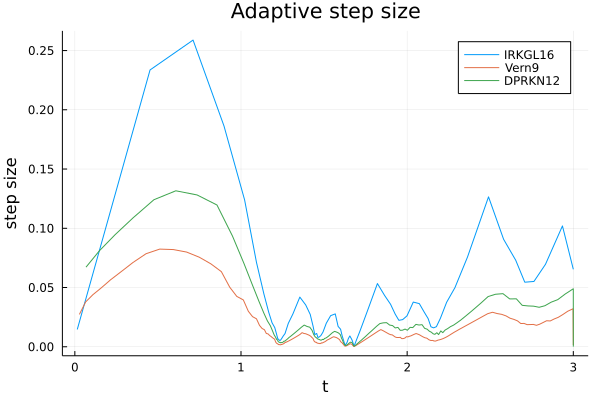

In [10]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(sol1.t[2:end],steps1, label="IRKGL16")
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot!(sol9.t[2:end],steps9, label="Vern9")
steps8 =sol8.t[2:end]-sol8.t[1:end-1]
plot!(sol8.t[2:end],steps8, label="DPRKN12")

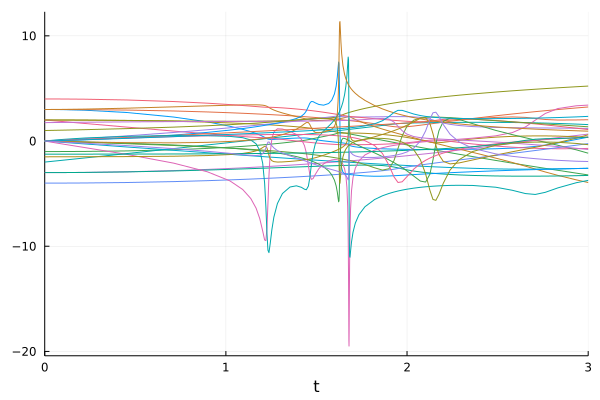

In [11]:
plot(sol1, label="")

### Energy Error

In [12]:
setprecision(BigFloat, 256)
u0256 =InitialPleiades(BigFloat)
Gm256=BigFloat.([1,2,3,4,5,6,7])

E0=NbodyEnergy(u0256,Gm256)

ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol1.u)./E0.-1;
ΔE9 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol9.u)./E0.-1;
ΔE8 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm256), sol8.u)./E0.-1

(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE9))), Float32(maximum(abs.(ΔE8))))

(2.222477f-14, 3.0723822f-12, 9.0261023f-14)

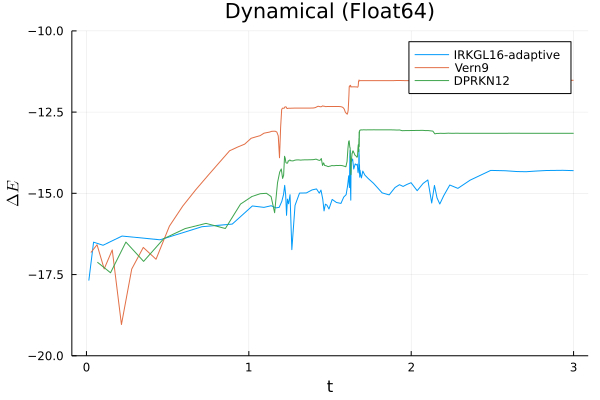

In [13]:
ylimit1=-20
ylimit2=-10
plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-adaptive", title="Dynamical (Float64)",
     ylims=(ylimit1,ylimit2),)
plot!(sol9.t,log10.(abs.(ΔE9)), label="Vern9",
     ylims=(ylimit1,ylimit2),)
plot!(sol8.t,log10.(abs.(ΔE8)), label="DPRKN12",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Float128 Computations (General ODE Problem)

In [14]:
setprecision(BigFloat, 108);

### Vern9

In [15]:
sol19 =solve(prob128,Vern9(), abstol=1e-20,reltol=1e-20);
sol19.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  39122
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          2445
Number of rejected steps:                          0

### IRKGL16

In [16]:
sol11 = solve(prob128,IRKGL16(mixed_precision=false),reltol=1e-20, abstol=1e-20,adaptive=true)  
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  37424
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          275
Number of rejected steps:                          52

### IRKGL16 (Mixed-Precision)

In [17]:
sol12 = solve(prob128,IRKGL16(mixed_precision=true),reltol=1e-20, abstol=1e-20,adaptive=true)
sol12.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  14872
Number of function 2 evaluations:                  115584
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          275
Number of rejected steps:                          52

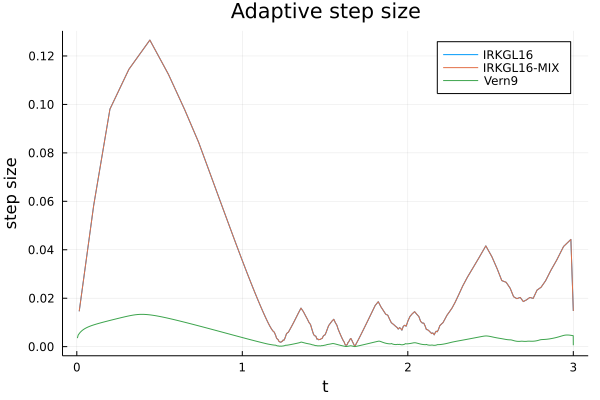

In [18]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps11 =sol11.t[2:end]-sol11.t[1:end-1]
plot!(sol11.t[2:end],steps11, label="IRKGL16")
steps12 =sol12.t[2:end]-sol11.t[1:end-1]
plot!(sol12.t[2:end],steps12, label="IRKGL16-MIX")
steps19 =sol19.t[2:end]-sol19.t[1:end-1]
plot!(sol19.t[2:end],steps19, label="Vern9")

<a href="#top">Back to the top</a>

## Float128 Computations (Second Order ODE)

In [19]:
setprecision(BigFloat, 108);

### Vern9

In [20]:
sol29 = solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20)
sol29.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  39122
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          2445
Number of rejected steps:                          0

### DPRKN12

In [21]:
sol28 = solve(prob2nd128,DPRKN12(),abstol=1e-20,reltol=1e-20);
sol28.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  16119
Number of function 2 evaluations:                  949
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          948
Number of rejected steps:                          0

### IRKGL16 

In [22]:
sol21 = solve(probdyn128,IRKGL16(), reltol=1e-20, abstol=1e-20,adaptive=true)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  21338
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          275
Number of rejected steps:                          52

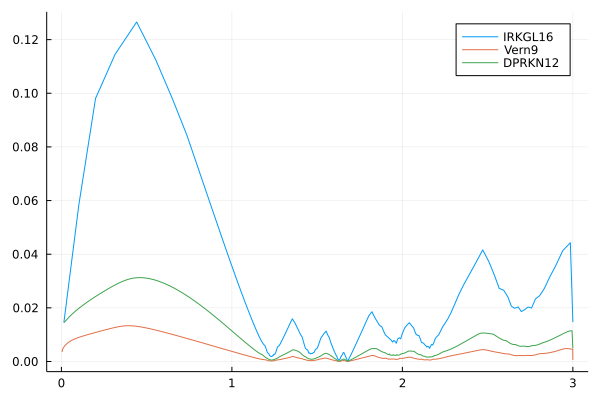

In [23]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps21 =sol21.t[2:end]-sol21.t[1:end-1]
plot(sol21.t[2:end],steps21, label="IRKGL16")
steps29 =sol29.t[2:end]-sol29.t[1:end-1]
plot!(sol29.t[2:end],steps29, label="Vern9")
steps28 =sol28.t[2:end]-sol28.t[1:end-1]
plot!(sol28.t[2:end],steps28, label="DPRKN12")

<a href="#top">Back to the top</a>

## Error in energy

In [24]:
setprecision(BigFloat, 256)
u0256 =InitialPleiades(BigFloat)
Gm256=BigFloat.([1,2,3,4,5,6,7])

E0=NbodyEnergy(u0256,Gm256)

ΔE11 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol11.u)./E0.-1
ΔE12 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol12.u)./E0.-1
ΔE19 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol19.u)./E0.-1
ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u)./E0.-1;
ΔE29 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol29.u)./E0.-1;
ΔE28 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm256), sol28.u)./E0.-1
(Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE12))) ,Float32(maximum(abs.(ΔE19))),Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE29))) , Float32(maximum(abs.(ΔE28))))

(1.0771821f-22, 1.0771821f-22, 1.10118944f-20, 1.0771821f-22, 1.10118944f-20, 1.8197767f-23)

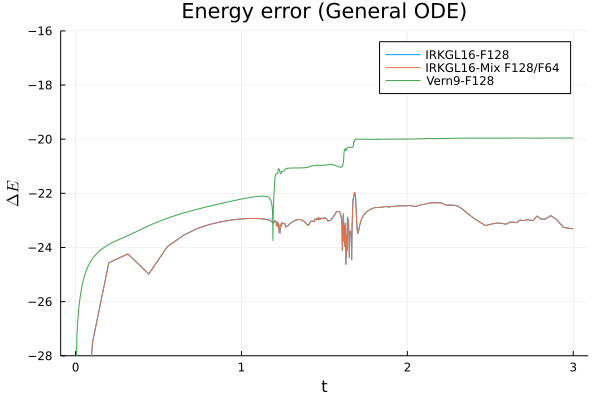

In [25]:
ylimit1=-28
ylimit2=-16
plot(title="Energy error (General ODE)", xlabel="t", ylabel=L"\Delta E")
plot!(sol11.t,log10.(abs.(ΔE11)), label="IRKGL16-F128",
     ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mix F128/F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol19.t,log10.(abs.(ΔE19)), label="Vern9-F128",
     ylims=(ylimit1,ylimit2),)

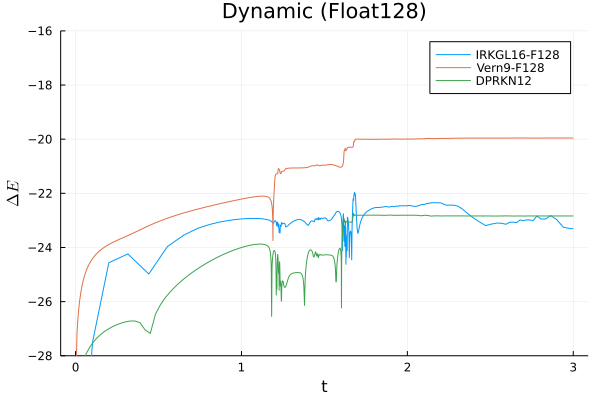

In [26]:
ylimit1=-28
ylimit2=-16
plot(title="Energy error (Second Order ODE)", xlabel="t", ylabel=L"\Delta E")
plot!(sol21.t,log10.(abs.(ΔE21)), label="IRKGL16-F128", title="Dynamic (Float128)",
     ylims=(ylimit1,ylimit2),)
plot!(sol29.t,log10.(abs.(ΔE29)), label="Vern9-F128",
     ylims=(ylimit1,ylimit2),)
plot!(sol28.t,log10.(abs.(ΔE28)), label="DPRKN12",
     ylims=(ylimit1,ylimit2),)